# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Know the data

We have 3 datasets
1. portfolio:
    This contains information about the different offers.
    
    Fields are as follows
    
    id (string) - offer id
    
    offer_type (string) - type of offer ie BOGO, discount, informational
    
    difficulty (int) - minimum required spend to complete an offer
    
    reward (int) - reward given for completing an offer
    
    duration (int) - time for offer to be open, in days
    
    channels (list of strings)

2. profile:
    Contains the inormation about the customers
    
    Fields are as follows
    
    age (int) - age of the customer
    
    became_member_on (int) - date when customer created an app account
    
    gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    
    id (str) - customer id
    
    income (float) - customer's income
    
3. transcript:
    Contians the information about the transaction
    
    Fields are as follows
    
    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    
    person (str) - customer id
    
    time (int) - time in hours since start of test. The data begins at time t=0
    
    value - (dict of strings) - either an offer id or transaction amount depending on the record

## 1. Portfolio data

In [5]:
portfolio.head(5)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
portfolio.shape

(10, 6)

In [7]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


## 2. Profile data

In [8]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.shape

(17000, 5)

In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


## 3. Transcript data

In [11]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Data Cleaning

In [14]:
# create Copy of each data set
df1 = portfolio.copy()
df2 = profile.copy()
df3 = transcript.copy()

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [16]:
df1.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [17]:
# channels column contains mutiple vlaues we split these values in columns 
channels = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)

C:\Users\talha_q1h4sv3\AppData\Local\Temp\ipykernel_15324\3759338959.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  channels = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)


In [18]:
df1 = pd.concat([df1,channels],axis=1)
df1.drop(columns="channels",inplace=True)

In [19]:
# rename id column to identify properly
df1.rename(columns={"id":"offer_id"},inplace=True)

In [85]:
df1

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


Cleaning Profile Data

In [20]:
df2.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [22]:
# check people with age 118
age_118 = df2.loc[df2["age"] == 118]

In [23]:
age_118.shape

(2175, 5)

there are 2175 persons with only date when they become member is valid, other fields are not valid 

In [24]:
2175+14825

17000

In [25]:
# renaming id column
df2.rename(columns = {'id':'person_id'}, inplace = True)


In [26]:
# chaning became_member_on column type to date type
df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')


In [27]:
df2.head()

,gender,age,person_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


### transcript data cleaning

In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [29]:
# replacing " " with "-" in events column
df3["event"] = df3["event"].str.replace(" ","-")

In [30]:
# rename person with person_id
df3.rename(columns = {'person':'person_id'}, inplace = True)


In [31]:
# count events in trancripts
df3["event"].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [32]:
event_types = pd.get_dummies(df3["event"])
event_types.head()

,offer-completed,offer-received,offer-viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [33]:
df3 = pd.concat([df3,event_types],axis=1)

In [34]:
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df3.value]

In [35]:
df3.drop(columns=["value","event"],inplace=True)

In [36]:
df3.head()

,person_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### merging all three datasets to make a master dataset

In [37]:
# first mergin Profile and transcript datasets on person_id
temp = pd.merge(df3, df2, on='person_id')


In [38]:
temp.head()

,person_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,F,75,2017-05-09,100000.0


In [39]:
# mergin portfolio dataset with temp based on offer_id
df = pd.merge(temp,df1,on='offer_id',how="left")
df

,person_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,F,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,F,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306530,912b9f623b9e4b4eb99b6dc919f09a93,594,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-09-26,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306531,3045af4e98794a04a5542d3eac939b1f,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
306532,3045af4e98794a04a5542d3eac939b1f,576,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,F,58,2016-10-20,78000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person_id         306534 non-null  object        
 1   time              306534 non-null  int64         
 2   offer-completed   306534 non-null  uint8         
 3   offer-received    306534 non-null  uint8         
 4   offer-viewed      306534 non-null  uint8         
 5   transaction       306534 non-null  uint8         
 6   offer_id          167581 non-null  object        
 7   amount            138953 non-null  float64       
 8   gender            272762 non-null  object        
 9   age               306534 non-null  int64         
 10  became_member_on  306534 non-null  datetime64[ns]
 11  income            272762 non-null  float64       
 12  reward            167581 non-null  float64       
 13  difficulty        167581 non-null  float64       
 14  dura

In [41]:
df.shape

(306534, 20)

# Data Exploration and Data Visualization

array([[<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'offer-completed'}>,
        <AxesSubplot:title={'center':'offer-received'}>,
        <AxesSubplot:title={'center':'offer-viewed'}>],
       [<AxesSubplot:title={'center':'transaction'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'reward'}>,
        <AxesSubplot:title={'center':'difficulty'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'email'}>,
        <AxesSubplot:title={'center':'mobile'}>,
        <AxesSubplot:title={'center':'social'}>,
        <AxesSubplot:title={'center':'web'}>]], dtype=object)

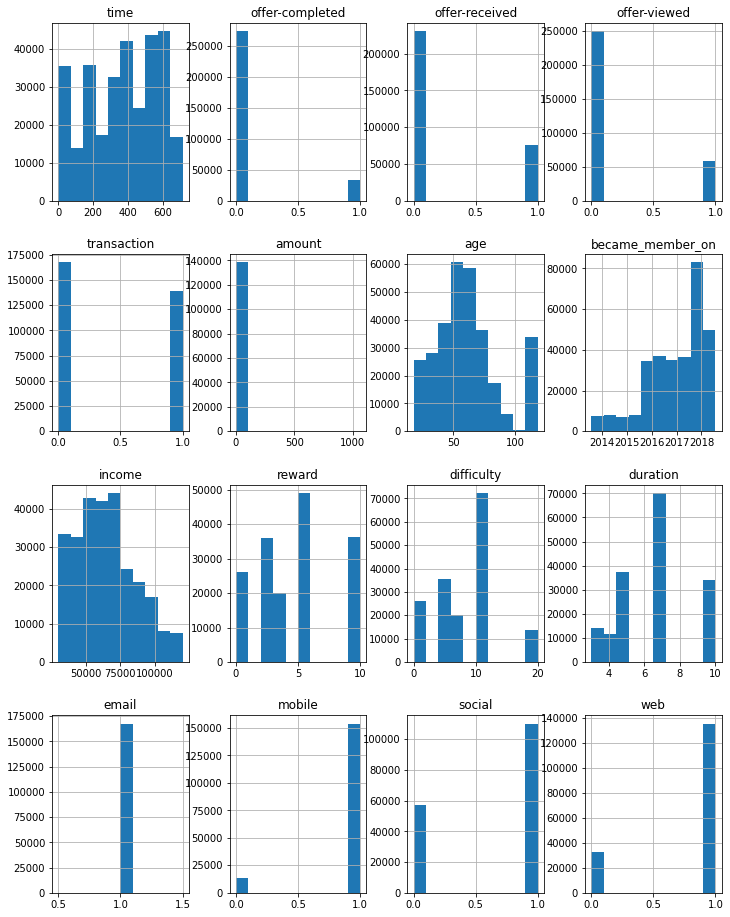

In [42]:
df.hist(figsize=(12,16))

In [43]:
# Explore Age Data

df.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Group Count')

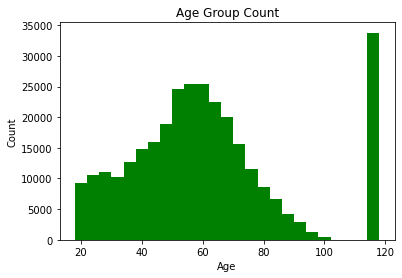

In [44]:
df.age.hist(grid=False,bins=25,color="green")
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Age Group Count")

Observations made
1. There are several entries in data with age 118 which is an outlier
2. People from age 30 to 70 visit more often to star bucks

In [45]:
# explore gender
df.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [46]:
df.gender.shape,df.age.shape

((306534,), (306534,))

<AxesSubplot:>

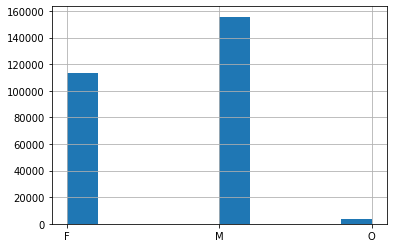

In [47]:
df.gender.hist()

<AxesSubplot:>

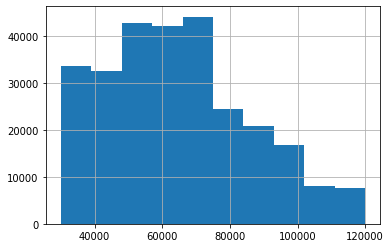

In [48]:
df.income.hist()

<AxesSubplot:xlabel='income', ylabel='age'>

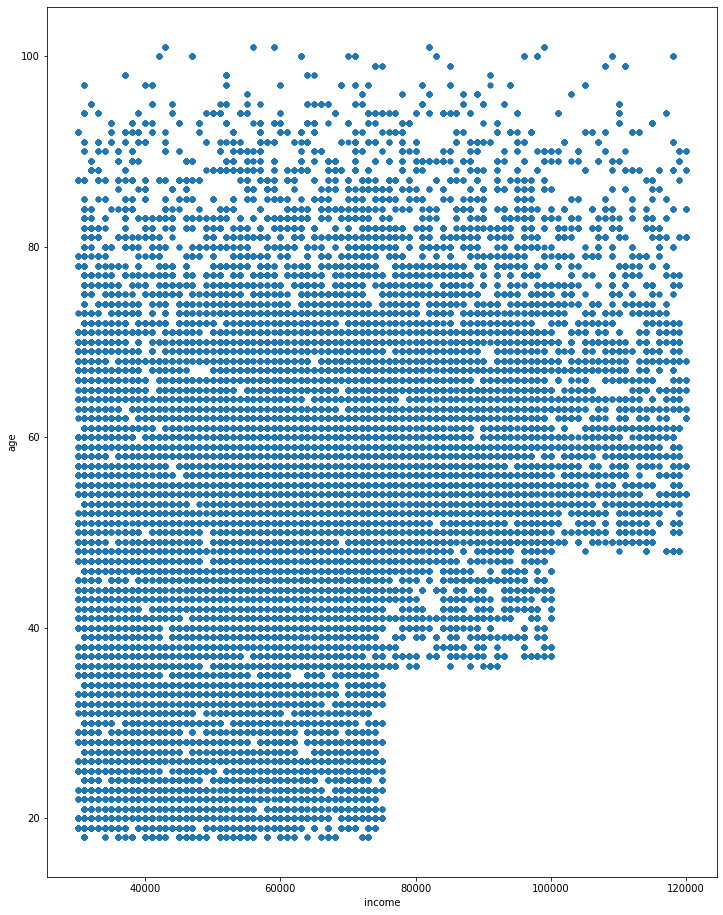

In [49]:
df.plot(x="income",y="age",kind="scatter",figsize=(12,16))

Observations:
    1. we saw tha people from age 20-35 earn not more than 70K
    2. people from age 35-50 earn not more than 100k

In [50]:
df_male =df.loc[(df.gender=="M") & df["offer-completed"]==1]

In [51]:
df_male.count()

person_id           16466
time                16466
offer-completed     16466
offer-received      16466
offer-viewed        16466
transaction         16466
offer_id            16466
amount                  0
gender              16466
age                 16466
became_member_on    16466
income              16466
reward              16466
difficulty          16466
duration            16466
offer_type          16466
email               16466
mobile              16466
social              16466
web                 16466
dtype: int64

In [52]:
df_female =df.loc[(df.gender=="F") & df["offer-completed"]==1]

In [53]:
df_female.count()

person_id           15477
time                15477
offer-completed     15477
offer-received      15477
offer-viewed        15477
transaction         15477
offer_id            15477
amount                  0
gender              15477
age                 15477
became_member_on    15477
income              15477
reward              15477
difficulty          15477
duration            15477
offer_type          15477
email               15477
mobile              15477
social              15477
web                 15477
dtype: int64

In [54]:
f_ofrcvd,m_ofrcvd = df.loc[(df.gender=="F")&(df["offer-received"]==1)].person_id.count(),df.loc[(df.gender=="M")&(df["offer-received"]==1)].person_id.count()

In [55]:
f_ofvw,m_ofvw = df.loc[(df.gender=="F")&(df["offer-viewed"]==1)].person_id.count(),df.loc[(df.gender=="M")&(df["offer-viewed"]==1)].person_id.count()

In [56]:
f_ofcom, m_ofcom = df.loc[(df.gender=="F")&(df["offer-completed"]==1)].person_id.count(),df.loc[(df.gender=="M")&(df["offer-completed"]==1)].person_id.count()

In [57]:
comp_age = pd.DataFrame({
    'offer_received': [m_ofrcvd,f_ofrcvd],
    'offer_viewed': [m_ofvw,f_ofvw],
    'offer_completed': [m_ofcom,f_ofcom],
    'gender': ["M","F"]
})

In [58]:
comp_age

,offer_received,offer_viewed,offer_completed,gender
0,38129,28301,16466,M
1,27456,20786,15477,F


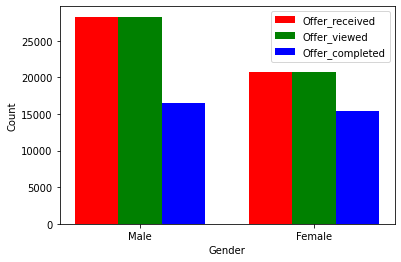

In [86]:
N = 2
ind = np.arange(N) 
width = 0.25
xvals = [28301, 20786]
bar1 = plt.bar(ind, xvals, width, color = 'r')
  
yvals = [28301, 20786]
bar2 = plt.bar(ind+width, yvals, width, color='g')
  
zvals = [16466, 15477]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')
  
plt.xlabel("Gender")
plt.ylabel('Count')
  
plt.xticks(ind+width,['Male', 'Female'])
plt.legend( (bar1, bar2, bar3), ('Offer_received', 'Offer_viewed', 'Offer_completed') )
plt.show()

Obsrvation:
    1. from above figure it is clear that Males received more offers than females
    2. Females are most likely to complete the offer rather than males
    3. Ratio of offer received and offer viewed is 1:1

In [60]:
df.to_csv("merged_data.csv")

# Modeling and Predictions :

In [61]:
df = pd.read_csv('merged_data.csv')


### Extracting required filed


In [62]:
data = df.loc[(df["offer-completed"]==1)]

In [63]:
data = data[["age","gender","income","offer_type"]]

In [64]:
data = data.dropna()

In [65]:
data.describe()

,age,income
count,32444.000000,32444.000000
mean,55.826624,69430.803847
std,16.809418,21604.250324
min,18.000000,30000.000000
25%,45.000000,53000.000000
50%,57.000000,69000.000000
75%,67.000000,85000.000000
max,101.000000,120000.000000


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 3 to 306502
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         32444 non-null  int64  
 1   gender      32444 non-null  object 
 2   income      32444 non-null  float64
 3   offer_type  32444 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


In [67]:
### Now we categorize age in different age groups and income in income groups 
data["age_group"] = pd.cut(data['age'], bins=[0,10,20,30,40,50,60,70,np.inf], labels=["0-10","10-20","20-30","30-40","41-50","51-60","61-70",">70"])

In [68]:
data.income.unique()

array([100000.,  70000.,  53000.,  51000.,  57000.,  71000.,  69000.,
        88000.,  41000.,  89000.,  33000.,  63000.,  40000.,  80000.,
        48000.,  38000.,  92000.,  96000.,  93000.,  35000.,  56000.,
        44000.,  87000.,  52000.,  76000.,  64000.,  72000., 117000.,
        55000., 112000.,  85000.,  91000., 107000.,  66000.,  58000.,
        98000., 119000.,  84000.,  49000.,  73000.,  78000.,  31000.,
        60000., 114000.,  47000.,  37000.,  79000.,  67000.,  68000.,
        50000.,  77000.,  83000.,  61000., 105000., 118000.,  46000.,
        99000.,  45000.,  95000.,  74000.,  59000., 101000.,  62000.,
        36000., 106000.,  54000.,  86000.,  34000.,  39000.,  94000.,
        75000.,  90000.,  32000.,  81000.,  42000., 110000.,  97000.,
       109000., 104000.,  65000.,  43000.,  82000., 113000., 103000.,
       108000., 115000., 102000., 116000., 111000.,  30000., 120000.])

In [69]:
data["income_group"] = pd.cut(data['income'], bins=[0,20000,40000,60000,80000,100000,120000,], labels=["0-20K","20k-40K","40K-60K","60K-80K","80K-100K",">100K"])

In [70]:
data.drop(columns=["age","income"],inplace=True)

In [71]:
data

,gender,offer_type,age_group,income_group
3,F,bogo,>70,80K-100K
14,F,bogo,>70,80K-100K
15,F,bogo,>70,80K-100K
39,M,bogo,61-70,60K-80K
40,M,discount,61-70,60K-80K
...,...,...,...,...
306454,F,bogo,51-60,60K-80K
306474,M,bogo,51-60,>100K
306481,M,bogo,51-60,>100K
306498,F,bogo,51-60,80K-100K


In [72]:
# applying one hot encoding for gender column
genders = {'O': 0, 'M': 1, 'F': 2}
data['gender'] = data['gender'].map(genders)

# applying one hot encoding for age_group column
age_group = {"0-10":0,"10-20":2,"20-30":3,"30-40":4,"41-50":5,"51-60":6,"61-70":7,">70":8}
data['age_group'] = data['age_group'].map(age_group)

# applying one hot encoding for age_group column
income_group = {"0-20K":0,"20k-40K":1,"40K-60K":2,"60K-80K":3,"80K-100K":4,">100K":5}
data['income_group'] = data['income_group'].map(income_group)

# applying one hot encoding for age_group column
offer_type = {"bogo":0,"discount":1}
data['offer_type'] = data['offer_type'].map(offer_type)

### Normalizing the data

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=data.columns)
print(scaled_df)


       gender  offer_type  age_group  income_group
0         1.0         0.0   1.000000          0.75
1         1.0         0.0   1.000000          0.75
2         1.0         0.0   1.000000          0.75
3         0.5         0.0   0.833333          0.50
4         0.5         1.0   0.833333          0.50
...       ...         ...        ...           ...
32439     1.0         0.0   0.666667          0.50
32440     0.5         0.0   0.666667          1.00
32441     0.5         0.0   0.666667          1.00
32442     1.0         0.0   0.666667          0.75
32443     1.0         1.0   0.666667          0.75

[32444 rows x 4 columns]


In [74]:
# Make test and train data
X = scaled_df.drop(columns=["offer_type"]).values
Y = scaled_df["offer_type"].values

In [75]:
X.shape,Y.shape

((32444, 3), (32444,))

In [76]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25, random_state = 0)

In [77]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

In [78]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns

def get_evaluation_metrics(y_true,y_pred):
    """
    Takes the y_true and y_pred values and prints the set of metrics
    """
    print("Accuracy:",accuracy_score(y_true,y_pred))
    print("F1_score:",f1_score(y_true,y_pred,pos_label=1))
    print("Recall_score:",recall_score(y_true,y_pred,pos_label=1))
    print("Precision:",precision_score(y_true,y_pred,pos_label=1))
    cf_matrix = confusion_matrix(y_true,y_pred)
    sns.heatmap(cf_matrix, annot=True,fmt='d')

Accuracy: 0.5199112316607076
F1_score: 0.6663239074550129
Recall_score: 0.912033779028853
Precision: 0.5249088699878494


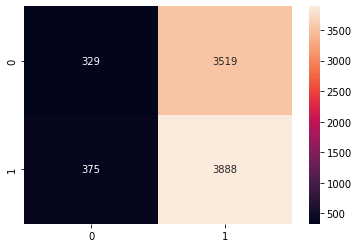

In [79]:
# Get Evaluations of SVM Model
get_evaluation_metrics(y_test,dtree_predictions)

### Applying cross validation

In [80]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator=dtree_model,
                X=X_train,
                y=y_train,
                cv=3,
                scoring='accuracy',
                n_jobs=-1)

array([0.52767846, 0.52878807, 0.52977438])

### Finding Best parameters for our model using GridSearchCV


In [81]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [82]:
# Getting the best parameters
grid_search_cv.best_estimator_


DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)

In [83]:
# Applying the best parameters
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

Accuracy: 0.5255825422266058
F1_score: 0.6890253757879424
Recall_score: 1.0
Precision: 0.5255825422266058


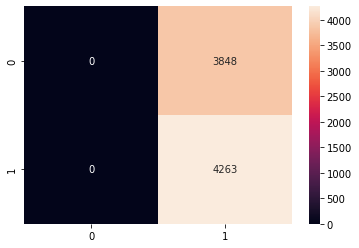

In [84]:
# Get Evaluations of SVM Model
get_evaluation_metrics(y_test,dtree_predictions)

# Conclusion:
    1. I found this project most challenging
    2. I was unable to get the proper results in modeling because on the imbalanced dataset
    3. Most of the records where outliers
Main challenges and potential improvement: Analysing and building the machne learning models .

    1. The main goal I chose, was to build something practical the company could use make their choices more efficient.
    2. But the results of the model seems like not so good . There is no change in rate of accuracy it remain constant .

# Refrences:
- [https://www.geeksforgeeks.org/](https://www.geeksforgeeks.org/)
- Udacity Leactures
- [https://pandas.pydata.org/](https://pandas.pydata.org/)
- [https://stackoverflow.com](https://stackoverflow.com)
- [Kaggle: Your Machine Learning and Data Science Community](https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data)
- [ML | Evaluation Metrics - GeeksforGeeks](https://www.geeksforgeeks.org/metrics-for-machine-learning-model/)
- Book: Hands–On Machine Learning with Scikit–Learn and TensorFlow
- [http://scikit-learn.org/stable/modules/naive_bayes.html](http://scikit-learn.org/stable/modules/naive_bayes.html)
- [https://en.wikipedia.org/wiki/Multiclass_classification](https://en.wikipedia.org/wiki/Multiclass_classification)
- [http://scikit-learn.org/stable/documentation.html](http://scikit-learn.org/stable/documentation.html)
- [http://scikit-learn.org/stable/modules/tree.html](http://scikit-learn.org/stable/modules/tree.html)
- [http://scikit-learn.org/stable/modules/svm.html#svm-kernels](http://scikit-learn.org/stable/modules/svm.html#svm-kernels)
- [https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/](https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/)
- [Multiclass classification using scikit-learn - GeeksforGeeks](https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/?ref=lbp)
- [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
    